# Safe Absorbing States

Number of Omega-automaton states (including the trap state): 4


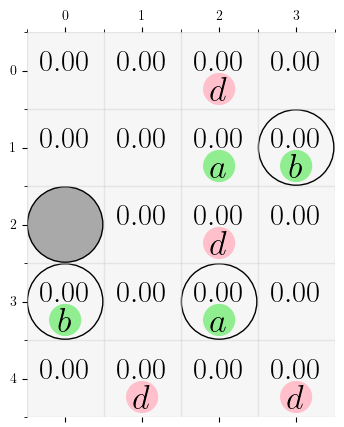

In [1]:
from NN import *
from LTL import *

%matplotlib inline
from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np
from matplotlib import pyplot as plt
import time

# LTL Specification
ltl = '(F G a | F G b) & G !d'

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])
display(oa)

# MDP Description
shape = (5,4)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'T'],
['B',  'E',  'E',  'E'],
['T',  'E',  'T',  'E'],
['E',  'E',  'E',  'E']
])

# Labels of the states
label = np.array([
[(),       (),     ('d',),()],
[(),       (),     ('a',),('b',)],
[(),       (),     ('d',),()],
[('b',),   (),     ('a',),()],
[(),       ('d',), (),    ('d',)]
],dtype=object)
# Colors of the labels
lcmap={
    ('a',):'lightgreen',
    ('b',):'lightgreen',
    ('d',):'pink'
}
p = 1
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap, p=p, figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot()

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)
max_rew = round(csrl.reward.max(), 3)

In [2]:
full_t = "(<> [] a \/ <> [] b) /\ [] ~d"

LTL_formula = parser.parse(full_t)
predicates=grid_mdp.get_predicates()
predicates

{'a': [6, 14], 'b': [7, 12], 'd': [2, 10, 17, 19]}

In [3]:
model = build_model(csrl.ch_states[(0,0,0,0)].shape, csrl.shape[-1])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 4, 4)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 5, 4, 32)     544         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 5, 4, 8)      1032        ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 160)          0           ['conv2d_1[0][0]']               
                                                                                              

In [4]:
model(csrl.ch_states[(0,0,0,0)][np.newaxis])

N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)

In [6]:
model.load_weights(f'first_case_{p}')

In [5]:
p

1

In [8]:
# model = build_model(csrl.ch_states[(0,0,0,0)].shape, csrl.shape[-1])

num_training_epochs =  0
num_test_epochs = 10
training = True 
epochs = 20
T = [200, 400]
K = 1
search_depth = 400

success_rates = []
succes_std = []
win_hist = []
train_history = []

for i in T:
    # TRAIN ##############################
    train_wins = 0
    # num_training_epochs = max(10, int(200-4*i))
    # num_training_epochs = int(200 - 1.5*i)
    N, W, Q, P, visited = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_training_epochs):
        t1 = time.time()
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = csrl.MC_learning(model, LTL_formula, predicates,
                N = N, W = W, Q = Q, P = P, C=3, tow=1, n_samples=100, visited=set(), start=None, search_depth=search_depth,
                verbose=0, T=i, K=K)
        # print('N',N[(0,0,0,0)])
        t2 = time.time()
        # print(t2-t1, " run episode")

        win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if win: train_wins+=1

        t3= time.time()
        if training and len(action_history)>0:
            if epoch==0:
                x_train = np.array(channeled_states)[:-1]
                y1_train = np.array(better_policy)
                y2_train = np.array(reward_history) + (check_LTL(LTL_formula, trajectory, predicates)[0]*max_rew)
                y2_train = y2_train[:-1]
            else:
                x_train = np.concatenate((x_train, np.array(channeled_states)[:-1]),0)
                y1_train = np.concatenate((y1_train, np.array(better_policy)),0)
                y2_train_curr = np.array(reward_history) + (check_LTL(LTL_formula, trajectory, predicates)[0]*max_rew)
                y2_train = np.concatenate((y2_train, y2_train_curr[:-1]),0)
            tr_hist = model.fit(x_train, [y1_train, y2_train], epochs=epochs, verbose=0)
            train_history += tr_hist.history['loss']
        win_hist.append(win)
        t4 = time.time()
        # print(t4-t3, " fit")
    print("Train wins:",train_wins,"/", num_training_epochs)

    # TEST ##############################
    test_wins = 0
    N, W, Q, P, visited = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_test_epochs):
        
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = csrl.MC_learning(model, LTL_formula, predicates,
                N = N, W = W, Q = Q, P = P, C=3, tow=1, n_samples=100, visited=set(), start=None, search_depth=search_depth, verbose=0, T=i, K=1)

        win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if win: test_wins+=1
        win_hist.append(win)

    success_rates.append(100*test_wins/num_test_epochs)
    temp = np.zeros(num_test_epochs)
    temp[:test_wins]=1
    std = np.sqrt(num_test_epochs*np.var(temp))
    succes_std.append((success_rates[-1]-std, success_rates[-1]+std))
    ###############################################################
    print("Test wins:",test_wins,"/",num_test_epochs)
    # print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    # print("Actions:", action_history)

Train wins: 0 / 0
[0.01558608 0.01567363 0.01569652 0.01534297 0.00013991 0.0007699
 0.00300123 0.00026005]
(0, 3, 1, 3)
[[[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
    [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
    [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
    [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]

   [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
    [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
      0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
    [ 0.00000000e+00  0.00000000e+00  0.000

UnboundLocalError: local variable 'next_move' referenced before assignment

In [55]:
model.save_weights(filepath=f'first_case_{p}')

In [6]:
state_history, channeled_states, trajectory, action_history, reward_history, better_policy = csrl.MC_learning(model, LTL_formula, predicates,
                N = N, W = W, Q = Q, P = P, C=3, tow=1, n_samples=100, start=(0,0), search_depth=search_depth, verbose=0, T=i, K=1)

--- : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


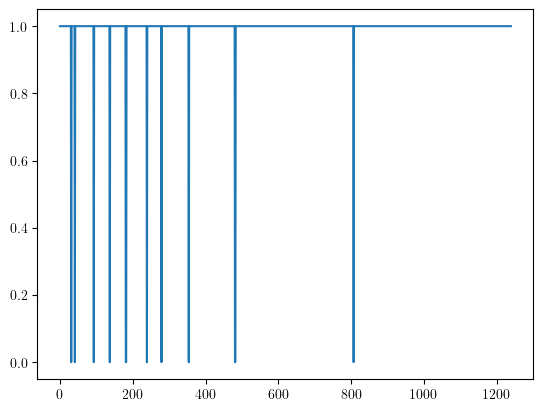

In [54]:
plt.plot(win_hist)

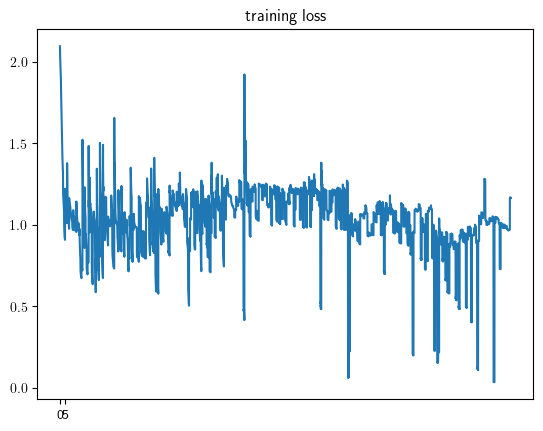

In [51]:
plt.plot(train_history)
plt.title("training loss")
plt.xticks(range(1,num_training_epochs*epochs,100), range(0,num_training_epochs,100//epochs));

[97.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]

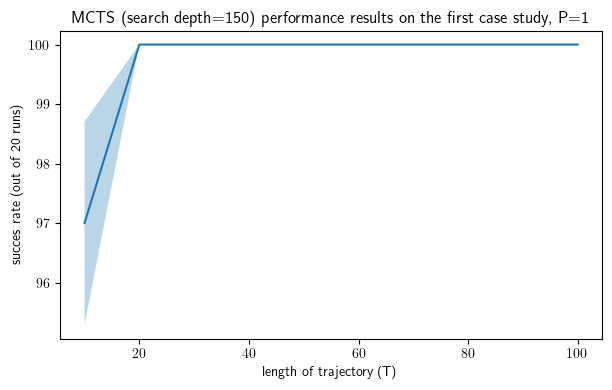

In [52]:
succes_std = np.array(succes_std)

plt.figure(figsize=(7,4))
plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3, label="MCTS area of 1 STD")

plt.plot(T, success_rates)
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate (out of 20 runs)")
plt.title("MCTS (search depth="+str(search_depth)+") performance results on the first case study, P="+str(p))
success_rates

[79, 83, 73, 78, 83, 85, 88, 85]

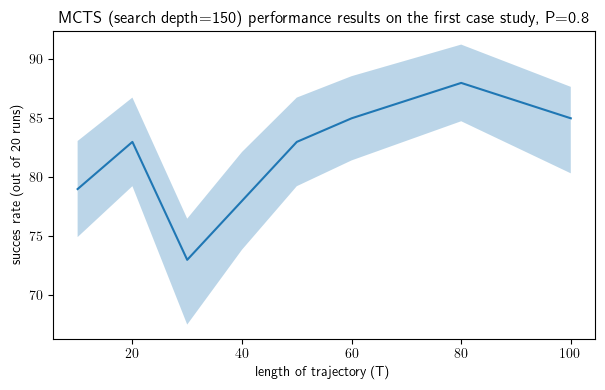

In [39]:
succes_std = np.array(succes_std)

plt.figure(figsize=(7,4))
plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3, label="MCTS area of 1 STD")

plt.plot(T, success_rates)
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate (out of 20 runs)")
plt.title("MCTS (search depth="+str(search_depth)+") performance results on the first case study, P="+str(p))
success_rates

In [41]:
success_rates = [79, 83, 73, 78, 83, 85, 88, 85]

In [6]:
from ipywidgets.widgets import IntSlider
from ipywidgets import interact

def plot_agent(t):
    csrl.mdp.plot(agent=state_history[t][2:], save=f'test/{t}.png')
t=IntSlider(value=0,min=0,max=T-1)
interact(plot_agent,t=t)

interactive(children=(IntSlider(value=0, description='t', max=9), Output()), _dom_classes=('widget-interact',)…

<function __main__.plot_agent(t)>

In [3]:
Q=csrl.q_learning(T=100,K=100000)
np.save(f'Q1_{p}', Q)

In [4]:
value=np.max(Q,axis=4)
np.save(f'value1_{p}', value)
# csrl.plot(value,iq=(0,0),save='safe_absorbing_states_values.pdf')
# csrl.plot(value,iq=(0,0))

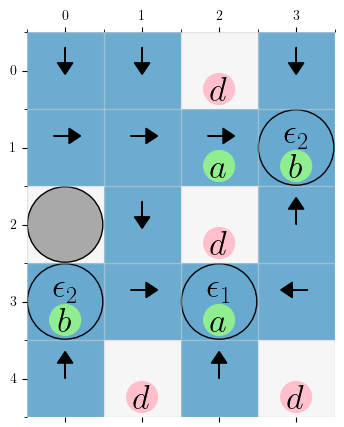

In [5]:
policy=np.argmax(Q,axis=4)
np.save(f'policy1_{p}', policy)
# csrl.plot(value,policy,iq=(0,0),save='safe_absorbing_states_policy.pdf')
csrl.plot(value,policy,iq=(0,0))

Load stuff

In [5]:
p=0.8
Q = np.load(f'Q1_{p}.npy')
value = np.load(f'value1_{p}.npy')
policy = np.load(f'policy1_{p}.npy')

In [6]:
episodes, rewards = csrl.run_Q_test(policy, LTL_formula, predicates, start=(0,0),T=100, runs=100, verbose=0)

Running 100 simulations with 100 time-steps...
Test finished with:
	success rate: 41 / 100 = 0.41


In [26]:
np.sqrt(1000*np.var(rew)), np.mean(rew)

(15.68537535413163, 0.563)

In [6]:
rewards_mean = []
rewards_std = []
n_runs = 100

x = list(range(3,100,10))+[100]
for i in x:
    episodes, rew = csrl.run_Q_test(policy, LTL_formula, predicates, T=i, start=None, runs=n_runs, verbose=0)
    rewards_mean.append(100*np.mean(rew))
    rewards_std.append((rewards_mean[-1]-np.sqrt(n_runs*np.var(rew)), rewards_mean[-1]+np.sqrt(n_runs*np.var(rew))))
rewards_std = np.array(rewards_std)

Running 100 simulations with 3 time-steps...
Test finished with:
	success rate: 68 / 100 = 0.68
Running 100 simulations with 13 time-steps...
Test finished with:
	success rate: 83 / 100 = 0.83
Running 100 simulations with 23 time-steps...
Test finished with:
	success rate: 76 / 100 = 0.76
Running 100 simulations with 33 time-steps...
Test finished with:
	success rate: 81 / 100 = 0.81
Running 100 simulations with 43 time-steps...
Test finished with:
	success rate: 71 / 100 = 0.71
Running 100 simulations with 53 time-steps...
Test finished with:
	success rate: 70 / 100 = 0.7
Running 100 simulations with 63 time-steps...
Test finished with:
	success rate: 80 / 100 = 0.8
Running 100 simulations with 73 time-steps...
Test finished with:
	success rate: 79 / 100 = 0.79
Running 100 simulations with 83 time-steps...
Test finished with:
	success rate: 75 / 100 = 0.75
Running 100 simulations with 93 time-steps...
Test finished with:
	success rate: 72 / 100 = 0.72
Running 100 simulations with 100 

(-10.0, 110.0)

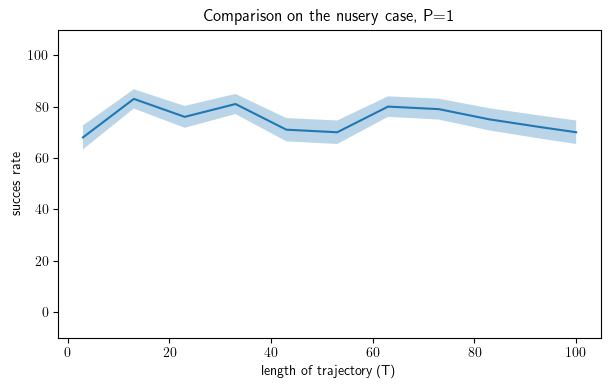

In [8]:
plt.figure(figsize=(7,4))

plt.fill_between(x, rewards_std[:,0], rewards_std[:,1], alpha=0.3)
plt.plot(x, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate")
plt.title("Comparison on the nusery case, P="+str(p))
plt.ylim(-10, 110)

# plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3)
# plt.plot(T, success_rates, label="MCTS")
# plt.legend()

Text(0.5, 1.0, 'CSRL performance results on the first case study, P=1')

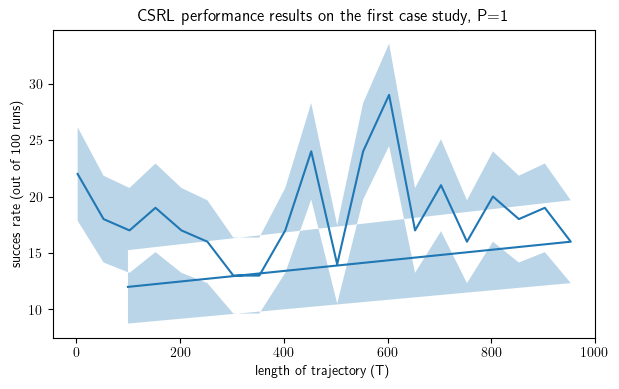

In [61]:
plt.figure(figsize=(7,4))
plt.fill_between(x, rewards_std[:,0], rewards_std[:,1], alpha=0.3, label="1 STD")

plt.plot(x, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate (out of 100 runs)")
plt.title("CSRL performance results on the first case study, P="+str(p))

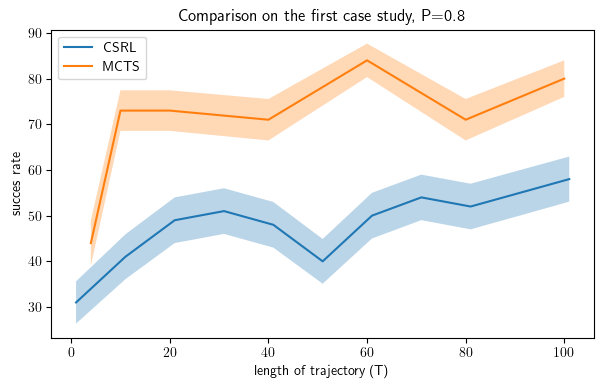

In [16]:
plt.figure(figsize=(7,4))

plt.fill_between(x, rewards_std[:,0], rewards_std[:,1], alpha=0.3)
plt.plot(x, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate")
plt.title("Comparison on the first case study, P="+str(p))

plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3)
plt.plot(T, success_rates, label="MCTS")
plt.legend()

In [11]:
rewards_backup = rewards.copy()

In [7]:
episodes, rewards = csrl.run_Q_test(policy, LTL_formula, predicates, start=(0,0),T=100, runs=1, verbose=4, animation='True')

Running 1 simulations with 100 time-steps...


interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…

episode 0 rew: False
states (if in acc) [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
Test finished with:
	success rate: 0 / 1 = 0.0


In [15]:
policy.shape

(1, 4, 5, 4)

interactive(children=(IntSlider(value=0, description='t'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_agent(t)>

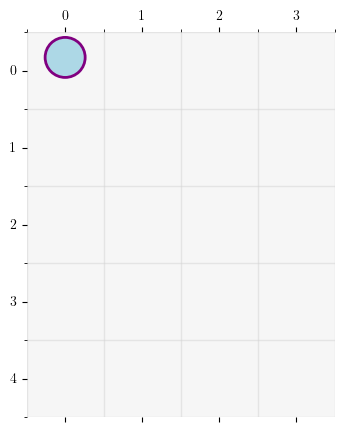

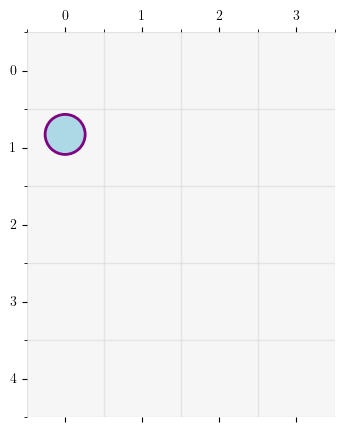

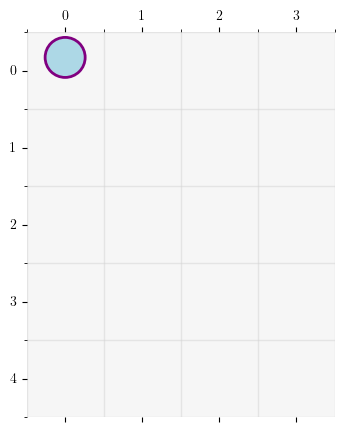

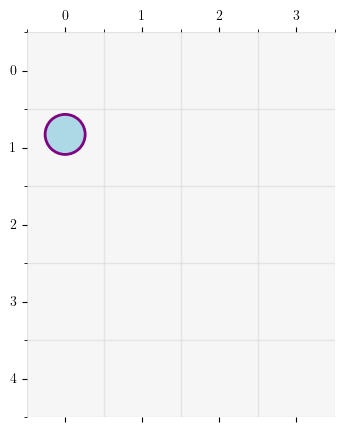

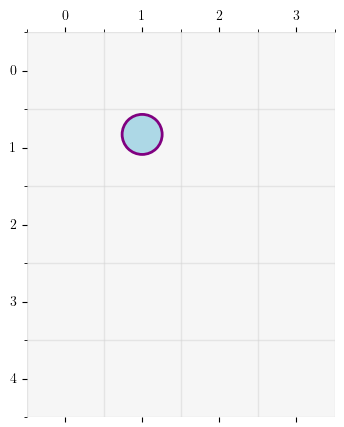

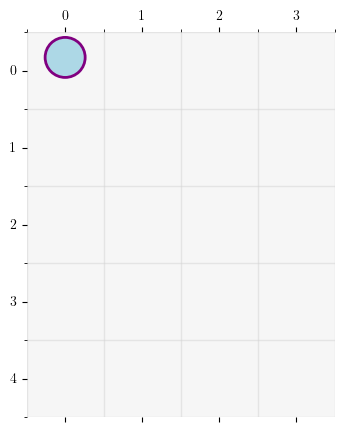

In [14]:
from ipywidgets.widgets import IntSlider
from ipywidgets import interact

def plot_agent(t):
    csrl.mdp.plot(agent=episodes[0][t][2:],policy=policy, save=f'test/{t}.png')
t=IntSlider(value=0,min=0,max=len(episodes[0])-1)
interact(plot_agent,t=t)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", font_scale=2.)
sns.set_style({'font.family': 'Times New Roman'})

# Maximal probabilities
pmax = np.array([
    [1.0, 1.0, 0.0, 1.0],
    [1.0, 1.0, 0.8, 1.0],
    [0.0, 1.0, 0.0, 1.0],
    [1.0, 1.0, 1.0, 1.0],
    [1.0, 0.0, 0.8, 0.0]
])

R = 100  # Repetitions
K_max = 18  # Log2 of the maximum episode length 
e = np.zeros((K_max, R))  # Error matrix
for k,K in enumerate(2**np.arange(K_max)):
    for i in range(R):
        Q=csrl.q_learning(T=100,K=K)
        value=np.max(Q,axis=4)
        e[k,i] = np.linalg.norm(value[0,0]-pmax)

mean = np.mean(e,axis=1)
std = np.std(e,axis=1)

# Plot the errors
K_min = 10  #  Log2 of the minimum episode length to be plotted
plt.figure(figsize=(6,6))
plt.errorbar(np.arange(K_min,K_max),mean[K_min:],yerr=std[K_min:],capsize=6,capthick=2,linewidth=3)
plt.xlabel(r'Number of Episodes')
plt.xticks(np.arange(K_min,K_max),['$2^{'+str(i)+'}$' for i in np.arange(K_min,K_max)])
plt.ylabel('L2 Norm of Errors')
plt.yticks(np.arange(0.0,1.1,0.1))
plt.grid(True)
plt.gca().xaxis.set_label_coords(0.4, -0.14)
plt.gca().set_facecolor('whitesmoke')
# plt.savefig('convergence.pdf',bbox_inches='tight')

KeyboardInterrupt: 